In [5]:
import sys
sys.path.append("/p300s/wangmx_group/xutingfeng/SIS/")


In [6]:

from sis.dataset import SISDataset
import torch 
import transformers 
from sis.model.sismodel import DoubleTransformerModel
from sis.utils import modelParametersNum, try_gpu

# Step1 dataset load 
# device = try_gpu()
device = "cuda:1"

sisdataset = SISDataset(root_dir="/p300s/wangmx_group/xutingfeng/SIS/sis/dataset/total_data.csv", device = device)

aa_vocab = sisdataset.aa_vocab
sis_datasetDict = sisdataset.dataset_dict

train_dataloader = torch.utils.data.DataLoader(sis_datasetDict["train"], batch_size=4, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(sis_datasetDict["test"], batch_size=4, shuffle=True)




Using custom data configuration default-52200760334198e7
Reusing dataset csv (/home/xutingfeng/.cache/huggingface/datasets/csv/default-52200760334198e7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-52200760334198e7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-bec2fd355b0cb7d7.arrow
Loading cached processed dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-52200760334198e7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-d7b3eee632703ea9.arrow


Loading cached processed dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-52200760334198e7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-0f1986b4010acd7d.arrow


Loading cached processed dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-52200760334198e7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-fbd879c251d0f77b.arrow
Loading cached split indices for dataset at /home/xutingfeng/.cache/huggingface/datasets/csv/default-52200760334198e7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f445a5304f7ba125.arrow and /home/xutingfeng/.cache/huggingface/datasets/csv/default-52200760334198e7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-cfda44d28db5f2dc.arrow


In [18]:
from sis.train import train
from torch import nn 
from torch.utils.tensorboard import SummaryWriter
import os.path as osp
import os 
from sis.model.embedding import EmbeddingLayer, OnehotLayer
from sis.dataset.EmbeddingData.parse import load_expasy_embedding_dict

# Step2 build model
N = 4
d_ff = 164
dropout = 0.3
length = sisdataset.SLF_max_length + sisdataset.SRnase_max_length

embedding_layer = EmbeddingLayer(aa_embedding_dict=load_expasy_embedding_dict(), aa_vocab=aa_vocab)


model = DoubleTransformerModel(N = N,d_ff=d_ff, dropout=dropout, seq_length=length, EmbeddingLayer = embedding_layer) 

# Step3定义 optim and loss
optim = torch.optim.NAdam(model.parameters(), lr=1e-6)
loss = nn.CrossEntropyLoss()
print(modelParametersNum(model))
## log path and save path
model_name = model.__class__.__name__
log_path = f"/p300s/wangmx_group/xutingfeng/SIS/output/logs/{model_name}"

summaryWriter = SummaryWriter(log_path)  # 使用tensorboard记录loss

save_path = f"/p300s/wangmx_group/xutingfeng/SIS/output/model"
# Step4 train
train(net = model, train_dataIter= train_dataloader, test_dataIter= test_dataloader,loss=loss, optim=optim, summary_writer = summaryWriter, epochs=100, device=device,
 savemodel=False, 
#  save_path = save_path
 )



模型总参数个数：287139
287139
epoch 10 : train: mean loss/per 0.827 acc is 0.356 and time is 55.83968178250896review/per sec
test: loss 1.725 and acc is 0.467
epoch 20 : train: mean loss/per 0.829 acc is 0.373 and time is 48.58710414391575review/per sec
test: loss 1.653 and acc is 0.467
epoch 30 : train: mean loss/per 0.830 acc is 0.356 and time is 66.76287389285628review/per sec
test: loss 1.584 and acc is 0.400
epoch 40 : train: mean loss/per 0.831 acc is 0.373 and time is 43.25037419210509review/per sec
test: loss 1.584 and acc is 0.400
epoch 50 : train: mean loss/per 0.809 acc is 0.373 and time is 56.21883057786841review/per sec
test: loss 1.655 and acc is 0.400
epoch 60 : train: mean loss/per 0.828 acc is 0.322 and time is 46.989523701741845review/per sec
test: loss 1.651 and acc is 0.400
epoch 70 : train: mean loss/per 0.828 acc is 0.339 and time is 55.62058490814972review/per sec
test: loss 1.580 and acc is 0.400


KeyboardInterrupt: 

In [ ]:
for x in train_dataloader:
    x1 = x["SLF_Seq_token"]
    print(x1.shape)
    o = embedding_layer(x1)
    print(o.shape)
    break 

torch.Size([4, 420])
torch.Size([4, 420, 61])


In [11]:
from sis.train import test, predict

test(model, test_dataloader, loss)

(1.6609474420547485, 0.3333333333333333)

In [12]:
from itertools import chain
import pandas as pd 

iter_dataloader = train_dataloader

o = predict(iter_dataloader, model).cpu()
label = torch.concat([i["label"] for i in iter_dataloader]).cpu()

def flatten_list(x:list):
    return list(chain.from_iterable(x))
names = flatten_list([zip(i["SLF"], i["SRnase"]) for i in iter_dataloader])

pred = (o>0.5).int().flatten()


pd.DataFrame({"names":names, "pred":pred, "label":label})

,names,pred,label
0,"(S9-SLF1, S11-RNase)",1,0
1,"(S9-SLF9, S9-RNase)",1,1
2,"(S9-SLF3, S9-RNase)",1,0
3,"(S11-SLF1, S19-RNase)",1,0
4,"(S11-SLF2, S19-RNase)",1,0
5,"(S11-SLF1, S7-RNase)",1,0
6,"(S11-SLF3, S11-RNase)",1,0
7,"(S7-SLF2, S5-RNase)",1,0
8,"(S5-SLF6, S5-RNase)",1,0
9,"(S11-SLF3, S17-RNase)",1,0


In [13]:
from itertools import chain
import pandas as pd 

iter_dataloader = test_dataloader

o = predict(iter_dataloader, model)
label = torch.concat([i["label"] for i in iter_dataloader]).cpu()

def flatten_list(x:list):
    return list(chain.from_iterable(x))
names = flatten_list([zip(i["SLF"], i["SRnase"]) for i in iter_dataloader])

pred = (o>0.5).int().flatten()

pd.DataFrame({"names":names, "pred":pred, "label":label})

,names,pred,label
0,"(S5-SLF1, S5-RNase)",1,1
1,"(S11-SLF1, S17-RNase)",1,0
2,"(S5-SLF2, S9-RNase)",1,0
3,"(S9-SLF17, S9-RNase)",1,0
4,"(S5-SLF1, S17-RNase)",1,0
5,"(S9-SLF4, S9-RNase)",1,0
6,"(S7-SLF1, S9-RNase)",1,1
7,"(S5-SLF1, S11-RNase)",1,1
8,"(S7-SLF3, S7-RNase)",1,0
9,"(S7-SLF3, S11-RNase)",1,0


In [14]:
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np 


def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距,width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax



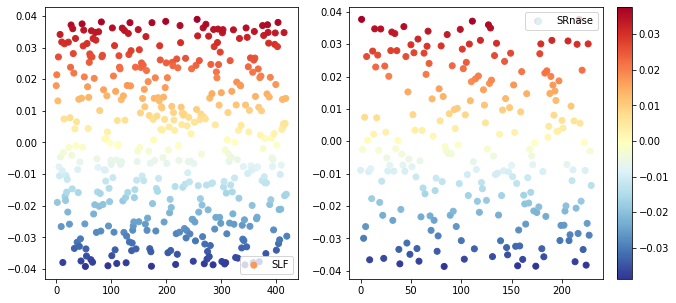

In [15]:
# show 最后一层的w

w = model.fc2.weight.flatten().cpu().detach().numpy()

cmap1 = cm.RdYlBu_r

w_SLF = w[:sisdataset.SLF_max_length]
w_SRnase = w[-sisdataset.SRnase_max_length:]

fig, axes = plt.subplots(1, 2,figsize=(10, 5))

axes[0].scatter(range(0, sisdataset.SLF_max_length), w_SLF, label="SLF", c=w_SLF,cmap= cmap1)
axes[0].legend()

im = axes[1].scatter(range(0, sisdataset.SRnase_max_length), w_SRnase, label="SRnase", c=w_SRnase, cmap = cmap1)
axes[1].legend()

cax = add_right_cax(axes[1], pad=0.02, width=0.02)
cbar = fig.colorbar(im, cax=cax)

plt.show()

In [16]:
# extract score paired with SLF_Seq and SRnase_Seq

score_tuple = []

for x in train_dataloader:
    o = model(x, return_scores=True)

    SLF_Seq = list(map(aa_vocab.lookup_tokens, x["SLF_Seq_token"].cpu().detach().numpy().tolist()))
    SRnase_Seq = list(map(aa_vocab.lookup_tokens, x["SRnase_Seq_token"].cpu().detach().numpy().tolist()))
    scores = model.scores.cpu().detach().numpy()
    [score_tuple.append([SLF_seq, SRnase_seq, score]) for SLF_seq, SRnase_seq, score in zip(SLF_Seq, SRnase_Seq, scores)]
    



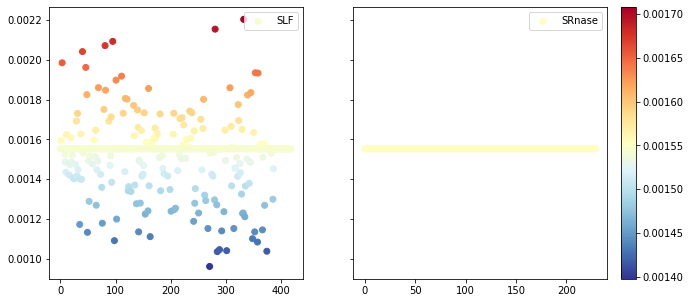

In [ ]:
import torch.nn.functional as F 

idx = 22

cmap1 = cm.RdYlBu_r

SLF_seq, SRnase_seq, score = score_tuple[idx]

# calculate score * w 
w = model.fc2.weight.flatten().cpu().detach().numpy()
score = score * w

score = F.softmax(torch.tensor(score),dim=-1).numpy()

SLF_seq_length = len(SLF_seq)
SRnase_seq_length = len(SRnase_seq)

score_SLF = score[:SLF_seq_length]
score_SRnase = score[-SRnase_seq_length:]

fig, axes = plt.subplots(1, 2,figsize=(10, 5),sharey=True)

axes[0].scatter(range(0, SLF_seq_length), score_SLF, label="SLF", c=score_SLF,cmap= cmap1)
axes[0].legend()

im = axes[1].scatter(range(0, SRnase_seq_length), score_SRnase, label="SRnase", c=score_SRnase, cmap = cmap1)
axes[1].legend()

cax = add_right_cax(axes[1], pad=0.02, width=0.02)
cbar = fig.colorbar(im, cax=cax)

plt.show()


In [22]:
list(model.encoder_SLF.parameters())[0]

Parameter containing:
tensor([[ 0.1011, -0.0372, -0.0380,  ...,  0.0012, -0.0088, -0.0358],
        [-0.0646,  0.0239, -0.1261,  ...,  0.0444,  0.0932, -0.0371],
        [ 0.0990, -0.0248,  0.0135,  ..., -0.0449, -0.0132, -0.0048],
        ...,
        [ 0.0816,  0.0135,  0.0216,  ..., -0.1062, -0.0200,  0.0910],
        [ 0.0687,  0.1277,  0.0400,  ...,  0.0077,  0.0891, -0.0863],
        [-0.0501, -0.0663, -0.0065,  ...,  0.0113,  0.0806,  0.0385]],
       device='cuda:1', requires_grad=True)

In [23]:
list(model.encoder_SRnase.parameters())[0]

Parameter containing:
tensor([[ 0.1012, -0.0376, -0.0382,  ...,  0.0009, -0.0090, -0.0362],
        [-0.0647,  0.0242, -0.1260,  ...,  0.0445,  0.0934, -0.0368],
        [ 0.0990, -0.0250,  0.0133,  ..., -0.0451, -0.0134, -0.0050],
        ...,
        [ 0.0815,  0.0139,  0.0219,  ..., -0.1060, -0.0198,  0.0913],
        [ 0.0686,  0.1281,  0.0402,  ...,  0.0079,  0.0893, -0.0860],
        [-0.0502, -0.0659, -0.0062,  ...,  0.0116,  0.0809,  0.0388]],
       device='cuda:1', requires_grad=True)